# Introduction

<div class="alert alert-block alert-warning">
<font color=black><br>

**What?** How to use XGBoost for time series forecasting

<br></font>
</div>

# Can XGBoost be used for TS forecasting?

<div class="alert alert-block alert-info">
<font color=black><br>

- XGBoost was designed for tabular datasets but it can still be used for TS forecasting.
- **However**:
    - It requires that the TS dataset be transformed into a supervised learning problem first. 
    - It requires the use walk-forward validation because k-fold cross validation would result in optimistically biased results.

<br></font>
</div>

# Import modules

In [1]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 20
# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Load the dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- We'll use a standard univariate time series dataset with the intent of using the model to make a **one-step forecast**.
- The dataset read is a time series because.
    - The time is in the feature columns.
    - The order in which the data were recorded is important.
- From the plot below, we can also see that there is no obviuos trend or seasonability.

<br></font>
</div>

In [2]:
series = read_csv('../../DATASETS/daily-total-female-births.csv', header = 0, index_col = 0)
values = series.values

In [3]:
series

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


Text(0.5, 0, 'days')

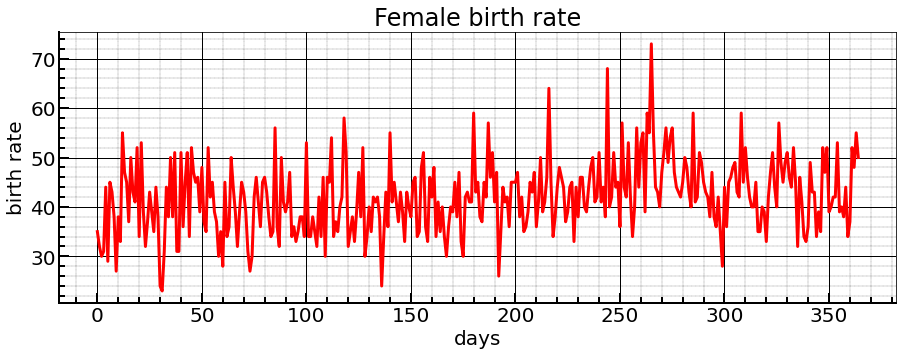

In [4]:
fig = pyplot.figure() 

plt.title("Female birth rate")

ax = fig.add_subplot(111) 

plt.plot(values, "r-", lw = 3)

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_ylabel("birth rate")
ax.set_xlabel("days")

# Transform a TS into a supervised dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- Given a TS dataset, we can re-cast the data as a upervised learning problem.
- We do that by getting rid of the time and using previous time steps as input variables and use the next time step as the output variable.
- This creates a shift in the data and the method is called **sliding windown**.
- This has also the downside if turning some row unasable.

<br></font>
</div>

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg.values

In [6]:
data = series_to_supervised(values, n_in = 6)

<div class="alert alert-block alert-info">
<font color=black><br>

- We'll just used pandas to nicely visualise the data.
- Essentially the the output is column y
- The feature are are all those columns from 1 to 6.
- The n6 features were given as an input by the argument **n_in**.

<br></font>
</div>

In [7]:
pd.DataFrame(data)

,0,1,2,3,4,5,6
0,35.0,32.0,30.0,31.0,44.0,29.0,45.0
1,32.0,30.0,31.0,44.0,29.0,45.0,43.0
2,30.0,31.0,44.0,29.0,45.0,43.0,38.0
3,31.0,44.0,29.0,45.0,43.0,38.0,27.0
4,44.0,29.0,45.0,43.0,38.0,27.0,38.0
...,...,...,...,...,...,...,...
354,53.0,39.0,40.0,38.0,44.0,34.0,37.0
355,39.0,40.0,38.0,44.0,34.0,37.0,52.0
356,40.0,38.0,44.0,34.0,37.0,52.0,48.0
357,38.0,44.0,34.0,37.0,52.0,48.0,55.0


In [8]:
# split dataset
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# Train the model

<div class="alert alert-block alert-info">
<font color=black><br>

- Making a function to call XGBoost for each forecast.

<br></font>
</div>

In [9]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

# Walk-forward validation

<div class="alert alert-block alert-info">
<font color=black><br>

- It would not be valid to fit the model on data from the future and have it predict the past. 
- The model must be trained on the past and predict the future.
- Right because of this, methods that randomize the dataset during evaluation, like **k-fold CV**, cannot be used. - The alternative is called **walk-forward validation**. This works like this:
    - Select a cut point selecting a cut point
    - All data except up to the cut point is used for training and the last data is used for testing.
<br><br>
- If we are interested in making a one-step forecast, e.g. one month:
    - Training on the training dataset and predicting the first step in the test dataset. 
    - We then add the real observation from the test set to the training dataset, refit the model, then have the model predict the second step in the test dataset.
    - Repeating this process for the entire test dataset will give a one-step prediction for the entire test dataset from which an error measure to evaluate the skill of the model is calculated.

<br></font>
</div>

In [10]:
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    print("TS length: ", len(data), ", train set length: ", len(train), " test set length: ", len(test))
    
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [11]:
# Let's get the performance of a persistent model? Is that what the tutorial meant?
mae, y, yhat = walk_forward_validation(data, 358)
print('MAE: %.3f' % mae)

TS length:  359 , train set length:  1  test set length:  358
>expected=43.0, predicted=45.0
>expected=38.0, predicted=43.0
>expected=27.0, predicted=43.0
>expected=38.0, predicted=45.0
>expected=33.0, predicted=27.2
>expected=55.0, predicted=35.9
>expected=47.0, predicted=37.7
>expected=45.0, predicted=39.3
>expected=37.0, predicted=32.4
>expected=50.0, predicted=34.9
>expected=43.0, predicted=36.4
>expected=41.0, predicted=51.6
>expected=52.0, predicted=43.6
>expected=34.0, predicted=50.4
>expected=53.0, predicted=47.7
>expected=39.0, predicted=46.3
>expected=32.0, predicted=48.3
>expected=37.0, predicted=52.5
>expected=43.0, predicted=47.5
>expected=39.0, predicted=43.9
>expected=35.0, predicted=45.2
>expected=44.0, predicted=49.7
>expected=38.0, predicted=43.3
>expected=24.0, predicted=45.2
>expected=23.0, predicted=46.3
>expected=31.0, predicted=29.3
>expected=44.0, predicted=47.8
>expected=38.0, predicted=47.3
>expected=50.0, predicted=29.4
>expected=38.0, predicted=35.2
>expecte

>expected=51.0, predicted=33.3
>expected=56.0, predicted=44.9
>expected=49.0, predicted=46.6
>expected=54.0, predicted=43.4
>expected=56.0, predicted=46.7
>expected=47.0, predicted=44.4
>expected=44.0, predicted=56.3
>expected=43.0, predicted=48.0
>expected=42.0, predicted=45.6
>expected=45.0, predicted=42.7
>expected=50.0, predicted=47.1
>expected=48.0, predicted=47.7
>expected=43.0, predicted=44.5
>expected=40.0, predicted=46.4
>expected=59.0, predicted=46.1
>expected=41.0, predicted=51.0
>expected=42.0, predicted=49.6
>expected=51.0, predicted=50.3
>expected=49.0, predicted=37.8
>expected=45.0, predicted=40.3
>expected=43.0, predicted=37.9
>expected=42.0, predicted=56.9
>expected=38.0, predicted=51.3
>expected=47.0, predicted=40.2
>expected=38.0, predicted=47.1
>expected=36.0, predicted=38.7
>expected=42.0, predicted=37.7
>expected=35.0, predicted=44.6
>expected=28.0, predicted=37.8
>expected=44.0, predicted=37.2
>expected=36.0, predicted=36.3
>expected=45.0, predicted=38.2
>expecte

In [12]:
# Let's get the performance for the last 12 days
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)

TS length:  359 , train set length:  347  test set length:  12
>expected=42.0, predicted=44.5
>expected=53.0, predicted=42.5
>expected=39.0, predicted=40.3
>expected=40.0, predicted=32.5
>expected=38.0, predicted=41.1
>expected=44.0, predicted=45.3
>expected=34.0, predicted=40.2
>expected=37.0, predicted=35.0
>expected=52.0, predicted=32.5
>expected=48.0, predicted=41.4
>expected=55.0, predicted=46.6
>expected=50.0, predicted=47.2
MAE: 5.957


<div class="alert alert-block alert-info">
<font color=black><br>

- We can see that the model performs better than a persistence model, achieving a MAE of about 6.462 births, compared to 7.03 births. 

<br></font>
</div>

# Post-processing

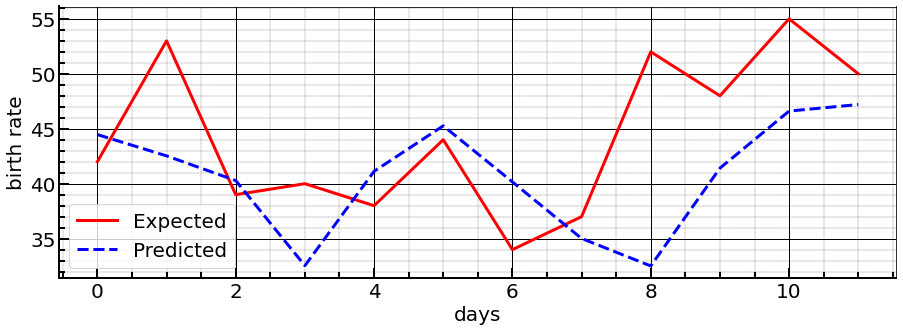

In [13]:
fig = pyplot.figure() 
ax = fig.add_subplot(111) 

pyplot.plot(y, "r-", label = 'Expected', lw = 3)
pyplot.plot(yhat, "b--", label = 'Predicted', lw = 3)

ax.grid(which = "major", linestyle='-', linewidth = '1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_ylabel("birth rate")
ax.set_xlabel("days")

pyplot.legend()
pyplot.show()

# Out-of-sample forecasting

<div class="alert alert-block alert-info">
<font color=black><br>

- It is time to make a prediction on a data outside the bounds used in the training.
- This is called **out-of-sample forecast**.
- In practice, what we do is to take the last 6 values of the series and predict the next one.

<br></font>
</div>

In [14]:
# The last 6 values are:
values[-6:]

array([[34],
       [37],
       [52],
       [48],
       [55],
       [50]])

In [15]:
# Transform the time series data into supervised learning
train = series_to_supervised(values, n_in = 6)
# Split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]

# Fit model (no early stopping is provided at the moment)
model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000)
model.fit(trainX, trainy)

# Construct an input for a new preduction
row = values[-6:].flatten()

# Make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: ->> %s, Predicted: ->> %.3f' % (row, yhat[0]))

Input: ->> [34 37 52 48 55 50], Predicted: ->> 42.708


# Conclusions

<div class="alert alert-block alert-danger">
<font color=black><br>

- It it possible to use a tree-based algorithm by recasting the time series as a supervised problem.
- Time series datasets can be transformed into supervised learning using a sliding-window representation.

<br></font>
</div>

# References

<div class="alert alert-warning">
<font color=black>

- https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
- [Link to dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv)

</font>
</div>